# Bootstrap used for Error estimation

Given a best guess at the parameters $\phi$ and $\delta t$ use resampling with replacement of the seismic data to bootstrap the covariance matrix.

From this we can calculate distributions of the eigenvectors, eigenvalues, and pearson correlation coefficients, which can be used to estimate the errors in the source polarisation and the splitting parameters (according to the Silver and Chan method, as well as the cross-correlation method).

How to chose the best guess parameters?  One idea would be to run the grid search and use the parameters that minimise $\lambda_2$, or to chose the parameters that maximise $\rho$.  If each approach is equally valid then some kind of joint solution may be derived by 

In [1]:
%load_ext autoreload
%autoreload 2

import splitwavepy as sw

import numpy as np
import matplotlib.pyplot as plt

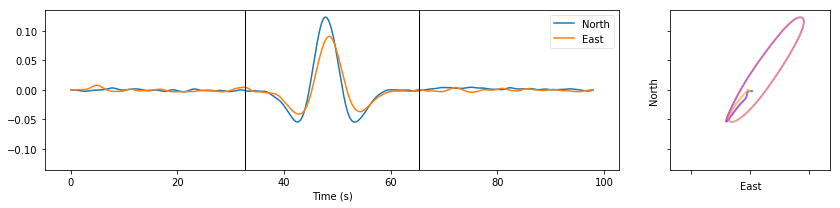

In [2]:
a = sw.SplitWave(split=(30,2), noise=0.01, pol=40).Py()
a.data.plot()
x = a.data.x
y = a.data.y

The code below is designed to quickly test bootstrapping after application of any arbitrarily selected splitting parameters.  It is designed in such a way as to replicate the process in the frequency domain.

In [3]:
from scipy.stats import gaussian_kde

def wrap_unsplit(x, y, rotate, dt, delta):
    """Applies a splitting correction with wrap-around of the data.
    This works in the time domain and is designed to replicate what happens in
    the frequency domain."""
    x, y = sw.core.core.rotate(x, y, rotate)
    shift = sw.core.core.time2samps(dt, delta)
    x = np.roll(x, shift)
#     x, y = sw.core.core.rotate(x, y, -rotate)
    return x, y


def bootcov(x, y, n=2000):
    """Resample x, y data and return n bootstrap covariance matrices."""
    
    # prep data with taper to window, rotate, 
    # and lag with wrap around (to replicate process in fourier domain)    
    bscov = np.empty((n, 2, 2))
    
    for ii in range(n):
        bsx, bsy = sw.core.core.bootstrap_resamp(x, y)
        bscov[ii] = sw.core.core.cov2d(bsx, bsy)
        
    return bscov

def get_kdes(bscov, pol=None):
    """Generate KDEs of rho, lam1/lam2, and spol (unless pol is specified).
    
    Uses the eigenvalue  method unless pol is specified,
    in which case will use the transverse minimisation method. """
    
    stdx = np.sqrt(bscov[:, 0, 0])
    stdy = np.sqrt(bscov[:, 1, 1])
    rho = bscov[:, 0, 1] / (stdx * stdy)
    r_kde = gaussian_kde(rho)
    
    if pol is None:
        # use eigenvector method.
        evals, evecs = np.linalg.eigh(bscov)
        rat = evals[:,1]/evals[:,0]
        spol = (np.rad2deg(np.arctan2(evecs[:,1,1], evecs[:,0,1]))+3690)%180-90
        rat_kde = gaussian_kde(rat)
        spol_kde = gaussian_kde(spol)
        return r_kde, rat_kde, spol_kde
    else:
        # use transverse min method
        rat = bscov[:,0,0]/bscov[:,1,1]
        rat_kde = gaussian_kde(rat)
        return r_kde, rat_kde
    

    
    
        
        

# def bscov2(bscov, pol=None):
    
        
        
        

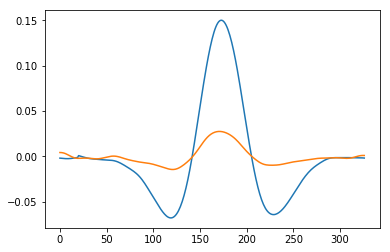

In [4]:
chp = a.data.chop()
x, y = chp.x, chp.y
sx, sy = wrap_unsplit(x, y, 30, 2, a.data._delta)
plt.plot(sx)
plt.plot(sy)
plt.show()

In [5]:
# check to see if result from my cov2d function gives same result
# as obtained using the gridcovfreq algorithm

mycov = sw.core.core.cov2d(sx, sy)
print(mycov)

gcov = sw.core.core.gridcovfreq(sx, sy)
rscov = sw.core.core.cov_reshape(gcov)
rscov[0][0]

np.allclose(mycov, rscov[0,0])

# what if we shift by a sample or n?
n = 10
mycov = sw.core.core.cov2d(np.roll(sx,n), sy)
print(mycov)

np.allclose(rscov[n,0], mycov)


[[0.00294241 0.00054352]
 [0.00054352 0.00010246]]
[[0.00294241 0.00047538]
 [0.00047538 0.00010246]]


True

In [6]:
bcov = bootcov(sx, sy, n=2000)
evals, evecs = np.linalg.eigh(bcov)

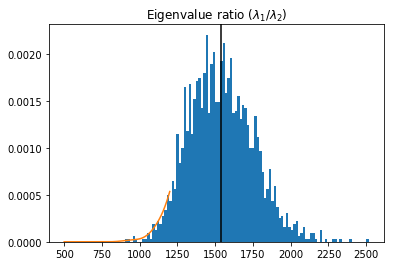

In [7]:
plt.close()
rat = evals[:,1]/evals[:,0]
plt.hist(rat, bins=100, density=True)
plt.axvline(np.mean(rat), color='k')
plt.title('Eigenvalue ratio ($\lambda_1/\lambda_2$)')

kde = gaussian_kde(rat)
plt.plot(np.arange(500,1200),kde.pdf(np.arange(500,1200)))


plt.show()

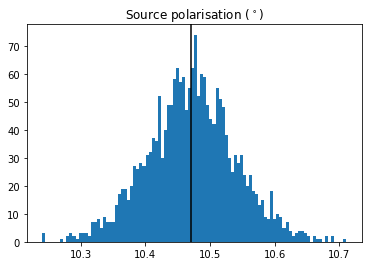

In [8]:

# evec1 = evecs[0,:,1]
# (np.rad2deg(np.arctan2(evec1[1],evec1[0]))+180)
angs = (np.rad2deg(np.arctan2(evecs[:,1,1], evecs[:,0,1]))+3690)%180-90
plt.hist(angs, bins=100)
plt.axvline(np.mean(angs), color='k')
plt.title('Source polarisation ($^\circ$)')
plt.show()

In [9]:
def covmap2rho(cov):
    stdx = np.sqrt(cov[:, 0, 0])
    stdy = np.sqrt(cov[:, 1, 1])
    rho = cov[:, 0, 1] / (stdx * stdy)
    return rho

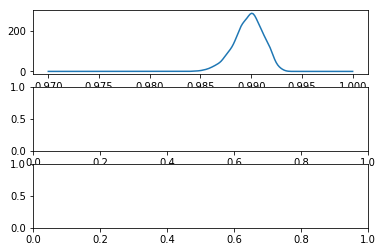

In [11]:
bcov = bootcov(sx, sy, n=2000)
rhokde, ratkde, spolkde = get_kdes(bcov)
fig, axarr = plt.subplots(3)
# axarr[0].hist(rhokde, bins=50, density=True)
# axarr[1].hist(ratkde, bins=50, density=True)
# axarr[2].hist(ratkde, bins=50, density=True)

# rho kde
rho_x = np.linspace(0.97,1,200)
axarr[0].plot(rho_x, rhokde.pdf(rho_x))
# rat_x
# azarr[1].plot()
# axarr[1].pl
plt.show()

In [30]:
np.sum(a.xc.pdf)

1.0

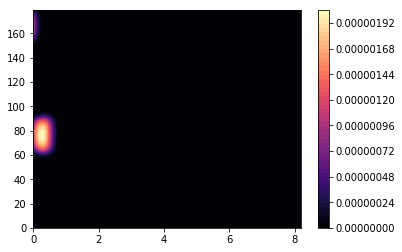

In [36]:

a = sw.SplitWave(split=(30, 2), noise=0.1, pol=20).Py()
plt.contourf(*a._grid, a.xc.pdf * a.sc.pdf, 50, cmap='magma')
plt.colorbar()
plt.show()

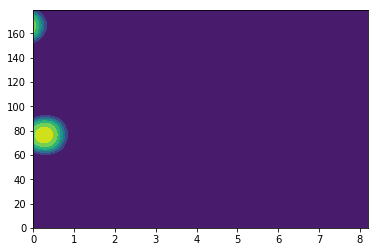

In [39]:
# likelihood raio -- is this useful?
plt.contourf(*a._grid, a.xc.pdf/a.xc.pdf.max())
plt.show()

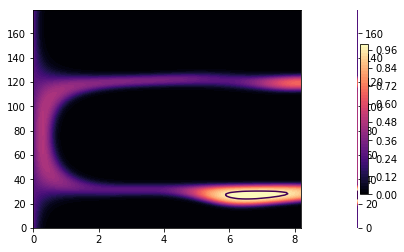

In [46]:
# more likelihood ratio
relative_likely = a.sc.pdf/a.sc.pdf.max()
plt.contourf(*a._grid, a.sc.pdf/a.sc.pdf.max(), 50, cmap='magma')
plt.colorbar()
plt.contour(*a._grid, relative_likely, levels=[0.95])
plt.show()

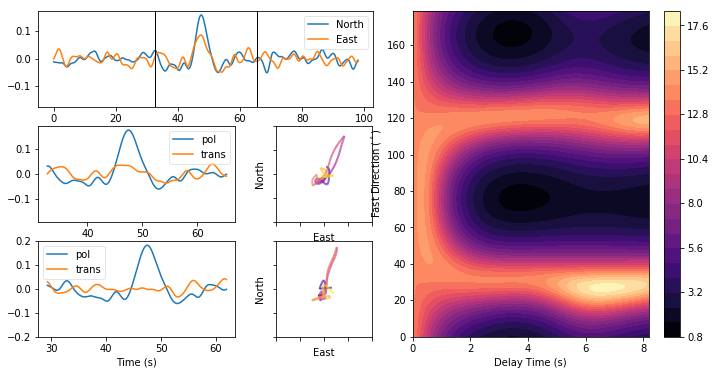

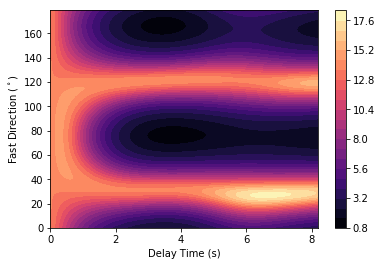

In [43]:
a.sc.psurf()

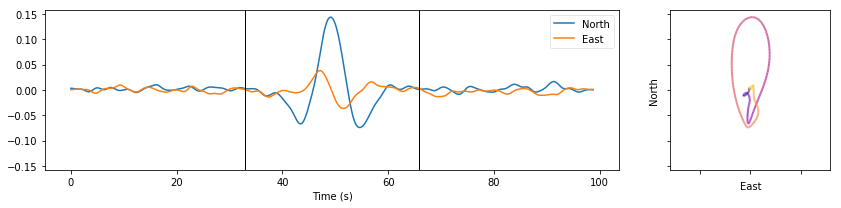

In [15]:
a = sw.SplitWave(split=(30,1.2), noise=0.03)
a.plot()


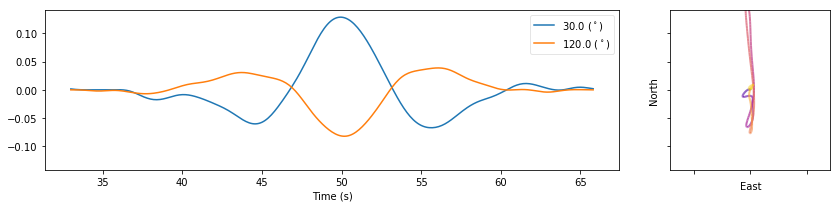

In [16]:
b = a._wrap_unsplit(30, 1.2)
b.plot()

In [19]:
a = sw.SplitWave(split=(30,1.2), noise=0.02, pol=10).Py()

In [20]:
r_kde, rat_kde, spol_kde = a._bootstrap_kdes(a.sc.fast, a.sc.lag)
xc_kde, _, _ = a._bootstrap_kdes(a.xc.fast, a.xc.lag)

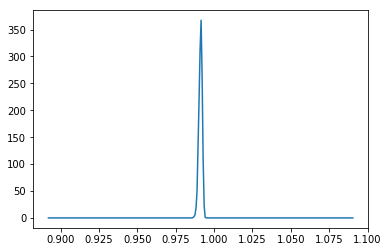

In [21]:
maxval = a.xc.vals.max()
x = np.linspace(maxval*0.9, maxval*1.1, 300)
plt.plot(x, xc_kde(x))
plt.show()

In [22]:
xc_kde(0.5)

array([0.])

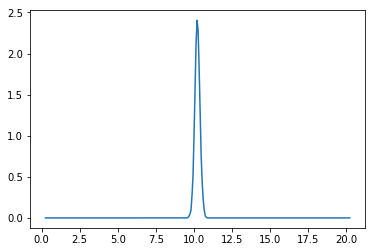

In [28]:
spol = a.sc.srcpol
x = np.linspace(spol-10, spol+10, 300)
plt.plot(x, spol_kde(x))
plt.show()

332.8379418708742


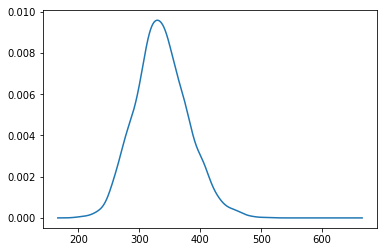

In [29]:
maxval = a.sc.vals.max()
print(maxval)
x = np.linspace(.5*maxval, 2*maxval, 3000)
plt.plot(x, rat_kde(x))
plt.show()

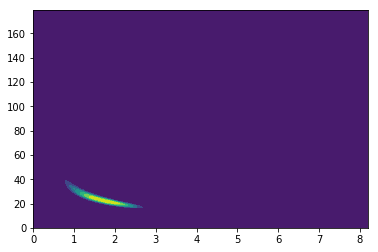

In [41]:
plt.contourf(*a._grid, rat_kde.pdf(a.sc.vals.flatten()).reshape((a.sc.vals.shape)))
plt.show()

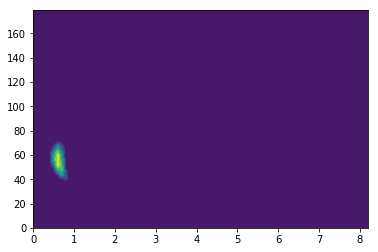

In [44]:
plt.contourf(*a._grid, xc_kde.pdf(a.xc.vals.flatten()).reshape((a.xc.vals.shape)))
plt.show()

In [38]:
a.sc.vals.flatten()

array([35.82217712, 35.82217712, 35.82217712, ...,  8.15700102,
        8.95359896,  9.85375154])

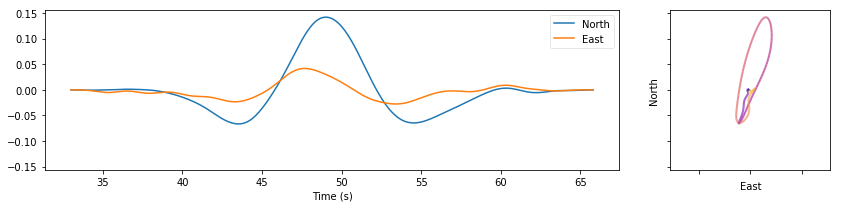

In [50]:
a.data.chop().taper(taper=0.2).plot()

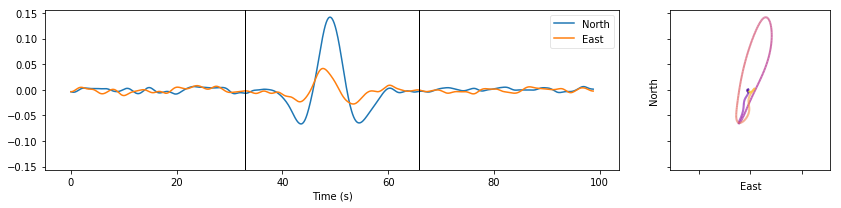

In [46]:
a.data.plot()

In [125]:
a = sw.SplitWave(split=(30,0), noise=0.02, pol=0).Py()

In [126]:
%timeit a._bootstrap_kdes(30, 1.2)

10 loops, best of 3: 109 ms per loop


In [127]:
%timeit a._bootstrap_kdes(30, 1.2, mode='rho')

10 loops, best of 3: 106 ms per loop


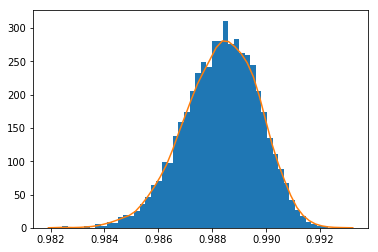

array([-7579014.55562973])

In [48]:
b = a.data._wrap_unsplit(30, 1.2)
x, y = b.x, b.y

# calculate bootstrap covariance matrices
n = 5000
bscov = np.empty((n, 2, 2))
for ii in range(n):
    bsx, bsy = sw.core.core.bootstrap_resamp(x, y)
    bscov[ii] = sw.core.core.cov2d(bsx, bsy)
    
stdx = np.sqrt(bscov[:, 0, 0])
stdy = np.sqrt(bscov[:, 1, 1])
rho = bscov[:, 0, 1] / (stdx * stdy)

plt.hist(np.abs(rho), 50)
r_kde = sw.core.core.kde(np.abs(rho))

lims = plt.axis()
limxs = np.linspace(lims[0], lims[1], 50)
plt.plot(limxs, r_kde.pdf(limxs))

plt.show()

r_kde.logpdf(0)
# b.plot()

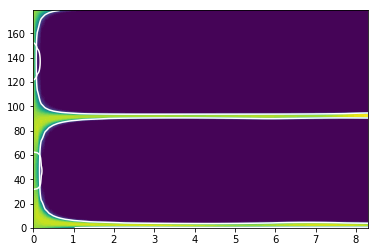

In [129]:
plt.contourf(*a._grid, a.sc.pdf, 50)
plt.contour(*a._grid, a.sc.pdf, levels=[sw.core.core.val_at_alpha(a.sc.pdf.flatten(), 0.05)], colors='w')
plt.contour(*a._grid, a.xc.pdf, levels=[sw.core.core.val_at_alpha(a.xc.pdf.flatten(), 0.05)], colors='w')
plt.contour
plt.show()

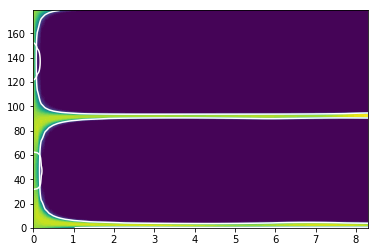

In [130]:
plt.contourf(*a._grid, a.sc.pdf, 50)
plt.contour(*a._grid, a.sc.pdf, levels=[sw.core.core.val_at_alpha(a.sc.pdf.flatten(), 0.05)], colors='w')
plt.contour(*a._grid, a.xc.pdf, levels=[sw.core.core.val_at_alpha(a.xc.pdf.flatten(), 0.05)], colors='w')
plt.contour
plt.show()

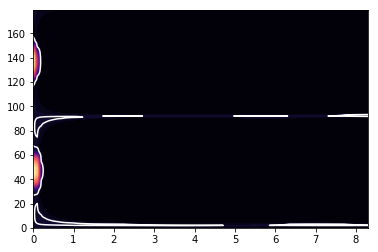

In [135]:
# a = sw.SplitWave(split=(30,1.2), noise=0.05, pol=0).Py()
# l = a.sc.likelihood * a.xc.likelihood
l = (a.sc.pdf + a.xc.pdf)/2
pdf = l / np.sum(l)
c68 = sw.core.core.val_at_alpha(pdf.flatten(), 0.32)
c95 = sw.core.core.val_at_alpha(pdf.flatten(), 0.05)
c99 = sw.core.core.val_at_alpha(pdf.flatten(), 0.01)
plt.contourf(*a._grid, pdf, 30, cmap='magma')
plt.contour(*a._grid, pdf, levels=[c68], colors='w')
plt.show()

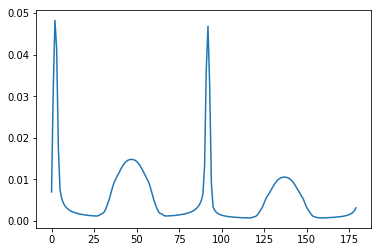

In [133]:
plt.plot(np.sum(pdf, axis=0))
plt.show()

In [140]:
fft = np.fft.fft(a.data.x)

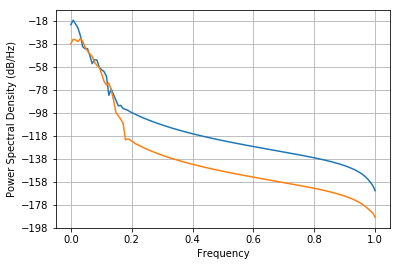

In [139]:
plt.psd(a.data.x)
plt.psd(a.data.y)
plt.show()

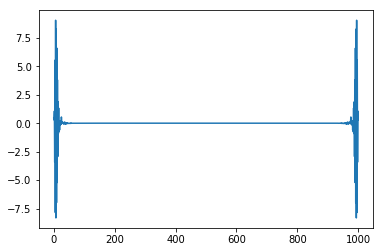

In [141]:
plt.plot(fft.real)
plt.show()

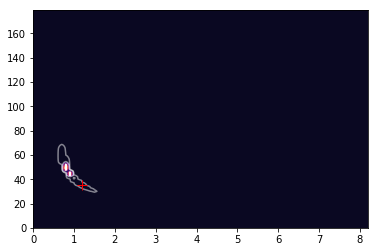

In [82]:
a = sw.SplitWave(split=(35,1.2), noise=0.01, pol=15).Py()
a.loglike = a.sc.loglike + a.xc.loglike
a95 = sw.core.core.val_at_alpha(a.sc.likelihood.flatten(), 0.05)
# plt.contourf(*a._grid, np.log(a.sc.likelihood) + np.log(a.xc.likelihood), cmap='magma')
plt.contourf(*a._grid, np.exp(a.loglike), cmap='magma')
plt.contour(*a._grid, a.loglike, levels=[a95], colors='w')
# plt.contourf(*a._grid, a.sc.loglike, cmap='magma')
s95 = sw.core.core.val_at_alpha(a.sc.pdf.flatten(), 0.05)
plt.contour(*a._grid, a.sc.pdf, levels=[s95],colors='w', alpha=0.5)
x95 = sw.core.core.val_at_alpha(a.xc.pdf.flatten(), 0.05)
plt.contour(*a._grid, a.xc.pdf, levels=[s95], colors='w', alpha=0.5)
plt.plot(1.2, 35, 'r+', markersize=10)
plt.show()

In [67]:
sw.core.core.val_at_alpha(a.sc.likelihood.flatten(), 0.05)

array(0.00363786)

In [65]:
a.loglike

array([[-293187.31490325, -290190.8889022 , -260946.82899274, ...,
        -210670.42400485, -236213.94834037, -263765.70770065],
       [-292817.93989998, -263346.43746583, -235615.01544528, ...,
        -234548.85554285, -261600.25579966, -290642.76096656],
       [-265682.21904407, -237742.56659496, -211576.39953739, ...,
        -260027.06595105, -288552.70020168, -295191.76017644],
       ...,
       [-113014.34872072, -104024.34044294,  -95815.48098888, ...,
        -144349.02274128, -133227.84886243, -122762.83798368],
       [-109070.48245204, -100551.48311793,  -92788.73860518, ...,
        -138878.60532692, -128280.87123691, -118326.26141897],
       [-105677.45180011,  -97610.5967254 ,  -90274.78811244, ...,
        -134009.32054921, -123919.72767136, -114458.62044687]])

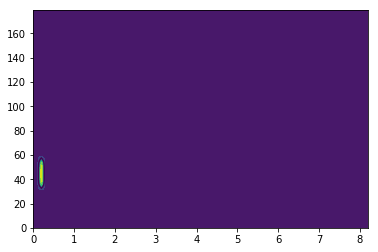

In [63]:
c95 = sw.core.core.val_at_alpha(a.xc.pdf.flatten(),0.05)

plt.contourf(*a._grid, a.xc.pdf)
plt.contour(*a._grid, a.xc.pdf, levels=[c95])
plt.show()

# Uncertainty estimation

Two differenct methods of estimating the uncertainty in the shear wave splitting parameters have been developed.  The F-test which is used in the minimum transverse energy or second eigenvalue method of Silver and Chan, and a bootstapping approach developed by Sandvol and Hearn.  Other methods such as the rotation correlation method and the splitting intensity method are not discussed here.

The F-test method works under the assumption that after application of the splitting parameters the residual energy on the transverse component is all noise.  If the noise is Gaussian, then its energy level will be chi-square distributed.  The energy level at the best fitting parameters sets a baseline.  One can then ask "what level of noise could reasonably be drawn from the same chi-square distribution?".  Confidence intervals on this level can be constructed using an F-test.  To do this requires The ratio of two independent chi square variables follows an F-distribution, where the shape of this distribution depends on the degrees of freedom. 


The method searches for the parameters that minimise the transverse energy and therefore the energy level associated with these The question asked of the method is essentially 

Walsh reviewed the Silver and Chan method and identified an error in the .  However the   method compares the ratio of the energy

Sandvol and Hearn used a completely different approach.  The residual transverse energy after correction with the best parameters is resequenced by convloving it with gaussian noise.  The energy on the noise trace remains constant.  However, splitting is unwinded and the grid search is reperformaed.  The method tests the stability of the solution to perturbations in the noise (but keeping the level of the noise fixed.)



# Bootstrapping to Bayes

We use bootstrapping to resample the corrected data with replacement in the analysis window. For each bootstrap resample of the data we calculate the covariance matrix from which we obtain the statistic of interest (e.g. minimum eigenvalue).  We do this many times to build up a pdf of the statistic.  We then use this pdf to construct a likelihood map over the parameter space. The likelihood of a parameter is given by mapping the value of the statistic to its value in the pdf function.

We convert the likelihood map to a posterior probability density function using Bayes theorem.

$P( \theta | d) = P( d | \theta ) \times P( \theta) / P(d)$

The posterior is simply the likelihood multiplied by  some prior and normalised so that it's total volume sums to unity.  The prior represents pre-existing knowledge of the parameter values.  In practice, a standard prior might be uniformly weighted over the range of expected parameter values (e.g., all possible fast angles, and delay times from 0 to 4 seconds.)

In [44]:
plt.axis()

(0.0, 1.0, 0.0, 1.0)